In [101]:
import math
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as sts
%matplotlib inline
from IPython.display import display, Latex
from sklearn import model_selection, datasets, linear_model, metrics
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid')

#### Задание 

1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   
    a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  
    b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

2. Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

5. Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

### Загрузим данные и посмотрим на них:

LIMIT_BAL:  размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 

default - индикатор невозврата денежных средств

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data.shape

(30000, 25)

In [4]:
data.isna().sum(axis = 0).sum()

0

In [5]:
data.describe(include = 'all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Рассмотрим гипотезы о равенстве медианного значения и распределений кредитного лимита среди вернувших и не вернувших кредит

In [6]:
data_ret = data[data.default == 0]
data_def = data[data.default == 1]

Посмотрим на данные (среднее значение кредитного лимита в выборках):

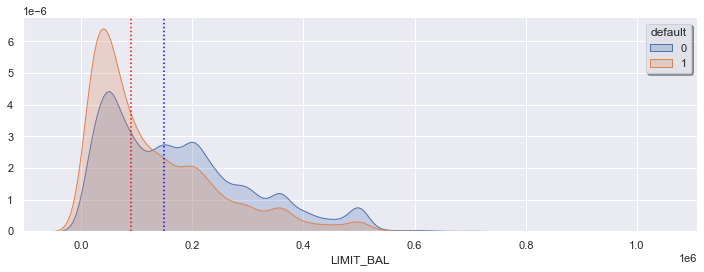

In [75]:
g = sns.FacetGrid(data=data[['LIMIT_BAL', 'default']], hue='default', 
                 height=4, aspect=2.5, legend_out=False)
g.map(sns.kdeplot, 'LIMIT_BAL', fill=True)
g.add_legend(shadow=True, framealpha=0.9)
g.ax.axvline(data_def.LIMIT_BAL.median(), ls=':', color='red')
g.ax.axvline(data_ret.LIMIT_BAL.median(), ls=':', color='blue')
plt.show()

Вертикальные прямые на графике -- медианные значения в выборках.

In [8]:
print(f'default=0: \n median = {data_ret.LIMIT_BAL.median()}')
print(f'default=1: \n median = {data_def.LIMIT_BAL.median()}')

default=0: 
 median = 150000.0
default=1: 
 median = 90000.0


Судя по графикам и точечным оценкам, медианы выборок существенно отличаются, проверим статистическую значимость с помощью медианного теста с нулевой гипотезой о равенстве медиан:

In [86]:
stat, p, med, tbl = sts.median_test(data_ret.LIMIT_BAL, data_def.LIMIT_BAL)
print(f'p-value = {p}')

p-value = 1.3471418011496707e-150


#### Достигаемый уровень значимости много меньше интересующего нас порога в 5%, а значит гипотеза о равенстве медиан уверенно отвергается, результат, очевидно, имеет не только статистическую значимость, т.к. точечные оценки отличаются почти на 70%.

Теперь воспользуемся критерием Манна-Уитни для проверки равенства рассматриваемых распределений

In [10]:
sts.mannwhitneyu(data_ret.LIMIT_BAL, data_def.LIMIT_BAL, alternative = 'two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

#### Получившийся уровень значимости много меньше 0.05, а значит, на этом уровне значимости гипотеза о равенстве распределений кредитного лимита в выборке вернувших и не вернувших кредит также уверенно отвергается.

### Теперь рассмотрим гендерный состав обоих подвыборок и выясним, отличается ли он.
Будем рассматривать этот категориальный признак как бинарный и считать долю мужчин среди вернувших и не вернувших кредит.

In [11]:
data_ret_sex = data_ret[['LIMIT_BAL', 'SEX']].replace(2, 0)
data_def_sex = data_def[['LIMIT_BAL', 'SEX']].replace(2, 0)
data_sex = data[['SEX', 'default']].replace(2, 0)
data_sex['sex'] = pd.Series(['man' if x == 1 else 'woman' for x in data_sex.SEX])

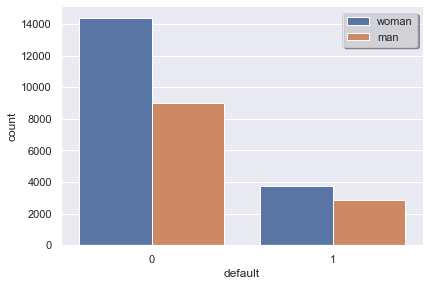

In [71]:
g = sns.catplot(data=data_sex, x='default', hue='sex', kind = 'count', legend_out=False,
                height=4, aspect=1.5)
g.ax.legend(shadow=True, framealpha=0.7)
plt.show()

Для начала построим доверительный интервал для разности долей мужчин в подвыборках:

In [13]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = sts.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return np.array((left_boundary, right_boundary))

In [14]:
sex_distribution_difference_confint = proportions_confint_diff_ind(data_ret_sex.SEX, data_def_sex.SEX).round(7)
print(f'sex distribution difference 95% confint: {sex_distribution_difference_confint}')

sex distribution difference 95% confint: [-0.0605481 -0.0336349]


#### 0 не входит в полученный интервал, а значит исходя из полученного результата на уровне доверия 95% можно сказать, что доли мужчин вернувших и не вернувших кредит среди всех заемщиков отличаются, причем вторая больше, т.е. мужчины в выборке с большим шансом не возвращали кредит, чем женщины.

Теперь повторим анализ с помощью Z-критерия для долей в 2 независимых выборках:

In [15]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - sts.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return sts.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - sts.norm.cdf(z_stat)

In [16]:
sex_distribution_difference_p_value = proportions_diff_z_test(proportions_diff_z_stat_ind(data_ret_sex.SEX, data_def_sex.SEX)).round(13)
print(f'sex distribution difference  p-value, considering H0 -- equal: {sex_distribution_difference_p_value}')

sex distribution difference  p-value, considering H0 -- equal: 4.5e-12


#### Z-критерий для разности долей в независимых выборках также уверенно отвергает нулевую гипотезу об одинаковом гендерном распределении (равенстве долей мужчин) в выборках.

### Далее, проверим влияет ли образование на то, вернет ли человек долг:

Для начала посмотрим на данные:

In [46]:
dic_ed = pd.DataFrame([{"EDUCATION": 0, "education": "доктор"},
                      {"EDUCATION": 1, "education": "магистр"},
                      {"EDUCATION": 2, "education": "бакалавр"},
                      {"EDUCATION": 3, "education": "выпускник школы"},
                      {"EDUCATION": 4, "education": "начальное образование"},
                      {"EDUCATION": 5, "education": "прочее"},
                      {"EDUCATION": 6, "education": "нет данных"}])
data_ed = data[["EDUCATION", "default"]].merge(dic_ed)

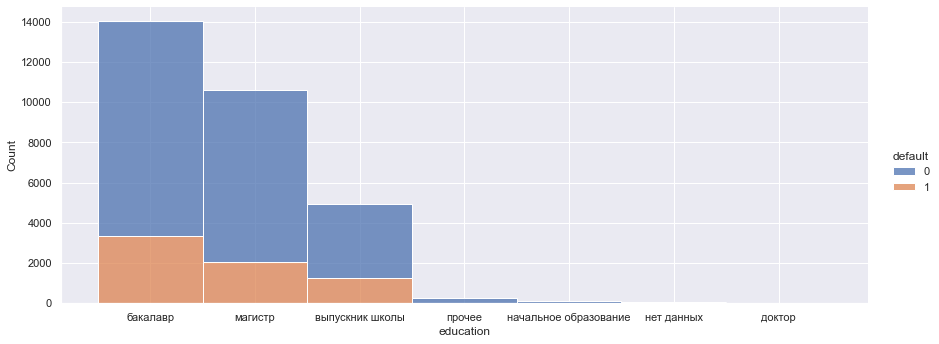

In [82]:
g = sns.displot(data=data_ed, x="education", hue='default', multiple='stack',
                height=5, aspect = 2.5)

In [83]:
default_education = pd.crosstab(data_ed.default, data_ed.education, 
                                rownames=['default'], colnames=['Education'])
default_education

Education,бакалавр,выпускник школы,доктор,магистр,начальное образование,нет данных,прочее
default,,,,,,,
0,10700,3680,14,8549,116,43,262
1,3330,1237,0,2036,7,8,18


Проверим гипотезу об отсутствии зависимости между возвратом долга и образованием с помощью критерия хи-квадрат:

In [85]:
chi2, p2, dof, expected = sts.chi2_contingency(default_education)
print(f'p-value = {p2}')

p-value = 1.2332626245415605e-32


Достигаемый уровень значимости много меньше 5% порога, а значит нулевая гипотеза об отсутствии зависимости шанса возврата кредита от уровня образования уверенно отвергается.

Посмотрим на разность ожидаемого и наблюдаемого количества возвратов, а потом нормируем это на количество людей с соответствующим уровнем образования, чтобы наглядно увидеть практическую значимость зависимости:

In [93]:
obs_exp_diff = pd.DataFrame(default_education - expected, columns = default_education.columns,
                           index = default_education.index)
obs_exp_diff

Education,бакалавр,выпускник школы,доктор,магистр,начальное образование,нет данных,прочее
default,,,,,,,
0,-226.564,-149.3596,3.0968,305.402,20.2076,3.2812,43.936
1,226.564,149.3596,-3.0968,-305.402,-20.2076,-3.2812,-43.936


In [94]:
obs_exp_diff/default_education.sum(axis=0)

Education,бакалавр,выпускник школы,доктор,магистр,начальное образование,нет данных,прочее
default,,,,,,,
0,-0.016149,-0.030376,0.2212,0.028852,0.164289,0.064337,0.156914
1,0.016149,0.030376,-0.2212,-0.028852,-0.164289,-0.064337,-0.156914


Следующий график демонстрирует процентное соотношение между возвратами и невозвратами кредитов в зависимости от  уровня образования, горизонтальной прямой обозначен ожидаемый уровень невозвратов, считаемый по всей выборке:

In [112]:
expected_default_rate = data_def.shape[0]/data.shape[0]

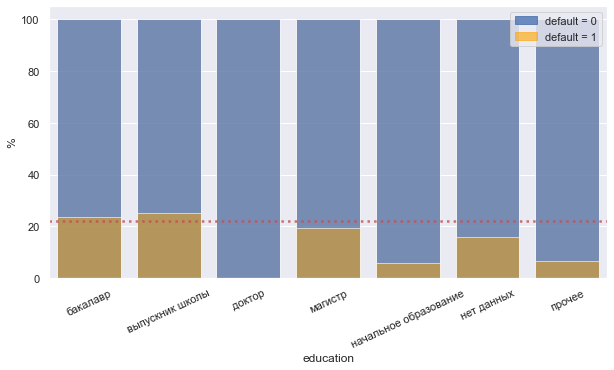

In [178]:
plt.figure(figsize=(10, 5))
total = data_ed.groupby('education')['default'].count().reset_index()
data_ed_def = data_ed.groupby("education")['default'].sum().reset_index()
data_ed_def['default'] = [i/j*100 for i,j in zip(data_ed_def['default'], total['default'])]
total['default'] = [i/j*100 for i,j in zip(total['default'], total['default'])]

bar_total = sns.barplot(x='education', y='default', data=total, color='b', alpha = 0.8)
bar_defaulters = sns.barplot(x='education', y='default', data=data_ed_def, color='orange', alpha = 0.6)
top_bar = mpatches.Patch(color='b', alpha = 0.8, label='default = 0')
bottom_bar = mpatches.Patch(color='orange', alpha = 0.6, label='default = 1')
plt.xticks(rotation=45)
plt.ylabel("%")
plt.xlabel("education")
plt.legend(handles=[top_bar, bottom_bar], loc='upper right')
plt.axhline(expected_default_rate*100, 0, 1, color='r', ls=':', lw=2.5, alpha=0.8)
plt.show()

Рассмотрим долю невозвратов в каждой подвыборке и выясним, влияет ли наличие того или иного уровня образования на отклонение шанса возврата от среднего:

In [157]:
ed_defaults = np.zeros(7).astype(int)
for i in range(7):
    ed_defaults[i] = data[data.default == 1][data.EDUCATION == i].shape[0]
ed_exp_obs = pd.DataFrame(ed_defaults, columns = ['observed'])
ed_exp_obs['expected'] = pd.Series((data['EDUCATION'].value_counts(sort = False)*expected_default_rate).values)
ed_exp_obs['difference'] = ed_exp_obs.observed - ed_exp_obs.expected

ed_exp_obs['exp_prop'] = ed_exp_obs.expected*0+expected_default_rate
ed_exp_obs['obs_prop'] = ed_exp_obs.observed/data['EDUCATION'].value_counts(sort = False)
ed_exp_obs['prop_diff'] = ed_exp_obs['obs_prop'] - ed_exp_obs['exp_prop']
ed_exp_obs.set_index([dic_ed.education], inplace=True)

ed_exp_obs

,observed,expected,difference,exp_prop,obs_prop,prop_diff
education,,,,,,
доктор,0,3.0968,-3.0968,0.2212,0.000000,-0.221200
магистр,2036,2341.4020,-305.4020,0.2212,0.192348,-0.028852
бакалавр,3330,3103.4360,226.5640,0.2212,0.237349,0.016149
выпускник школы,1237,1087.6404,149.3596,0.2212,0.251576,0.030376
начальное образование,7,27.2076,-20.2076,0.2212,0.056911,-0.164289
прочее,18,61.9360,-43.9360,0.2212,0.064286,-0.156914
нет данных,8,11.2812,-3.2812,0.2212,0.156863,-0.064337


In [ ]:
Построим диаграмму доли невозвратов для каждой подвыборки с ее доверительным интервалом:

In [162]:
lefts = np.zeros(7)
rights = np.zeros(7)
for i in range(7):
    sample1 = data[data.EDUCATION == i].default
    lefts[i], rights[i] = proportion_confint(sample1.sum(), sample1.shape[0],
                                            method = 'wilson')

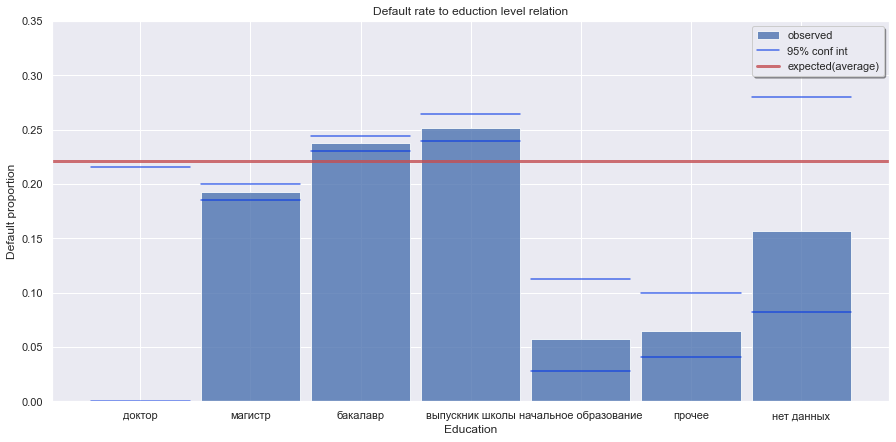

In [181]:
fig1, ax1 = plt.subplots(figsize = (15, 7))
#ax1.set_facecolor((0.88, 1.0, 0.94))
plt.rc('font', size=14)

x = range(7)
width = 0.9

line1 = ax1.bar(x, ed_exp_obs['obs_prop'], width, color = 'b', alpha = 0.8)

for i in range(7):
    ax1.axhline(lefts[i], (i-width/2+0.8)/7.6, (i+width/2+0.8)/7.6, 
              color = (0, 0.2, 0.9), alpha = 0.7)
    line0 = ax1.axhline(rights[i], (i-width/2+0.8)/7.6, (i+width/2+0.8)/7.6, 
              color = (0, 0.2, 0.9), alpha = 0.7)

line2 = ax1.axhline(expected_default_rate, 0, 1, color = 'r', alpha = 0.8,
            linewidth = 3)

ax1.set_title('Default rate to eduction level relation')
ax1.set_xlabel('Education')
ax1.set_ylabel('Default proportion')
ax1.set_ylim(top = 0.35)
ax1.set_xlim(left = -0.8, right = 6.8)
plt.xticks(ticks = x, labels = dic_ed.education)
#plt.xticks(rotation=25)
ax1.legend([line1, line0, line2], ['observed', '95% conf int', 'expected(average)'], shadow = True)
plt.show()

#### Как видно из графика, ни для одного из уровней образования (6 -- отсутствие данных) 95%-й доверительный интервал для доли невозвратов кредита не содержит среднего по всей выборке, что еще раз подтверждает влияние образования на шанс возврата долга, причем на данном уровне значимости гипотеза равенства доли возвратов средней отвергается для всех уровней образования без исключения. Также можно сделать вывод, что с большим среднего шансом не возвращают бакалавры и выпускники школ, а с меньшим - все остальные.

In [168]:
display(Latex('p-values for default\'s proportion of each lvl of education, where $H_0$ - equal to average:'))
ed_p_values = np.zeros(7)
print('p-values: ')
for i in range(7):
    sample1 = data[data.EDUCATION == i].default
    sample2 = data.default
    temp = proportions_diff_z_test(proportions_diff_z_stat_ind(sample1, sample2)).round(10)
    print(f' {dic_ed.education[i]}: {temp}')

<IPython.core.display.Latex object>

p-values: 
 доктор: 0.0461572293
 магистр: 5e-10
 бакалавр: 0.0001612852
 выпускник школы: 2.3067e-06
 начальное образование: 1.15604e-05
 прочее: 3e-10
 нет данных: 0.2686219274


#### Z-критерий для разности долей на уровне значимости 95% также уверенно отвергает нулевую гипотезу о равенстве наблюдаемой и ожидаемой доли возвратов в подбвыборках.

### Продолжим рассмотрение признаков, на очереди еще один категориальный - семейное положение:

In [184]:
dic_m = pd.DataFrame({"MARRIAGE": [0, 1, 2, 3], 
                      "marriage": ["отказываюсь ответить", "замужем/женат", "холост",
                                        "нет данных"]})
data_marr = data[['MARRIAGE', 'default']].merge(dic_m)

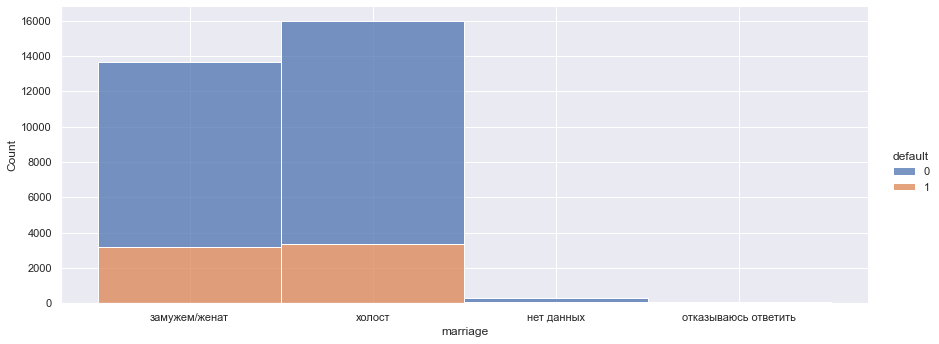

In [185]:
g = sns.displot(data=data_marr, x='marriage', hue='default', multiple='stack',
               height=5, aspect=2.5)

In [187]:
def_marr_cross = pd.crosstab(data_marr.default, data_marr.marriage,
                            rownames=['default'], colnames=['marriage'])
def_marr_cross

marriage,замужем/женат,нет данных,отказываюсь ответить,холост
default,,,,
0,10453,239,49,12623
1,3206,84,5,3341


Связь между семейным статусом и бинарным индикатором возврата кредита можно оценить с помощью коэффициента V Крамера, а статистическую значимость с помощью критерия хи-квадрат (использовать его мы можем, т.к. значения в каждой ячейке достаточно велики, а признаки бинарный и категориальный):

In [189]:
chi2_marr, p_marr, dof_marr, expected_marriage = stats.chi2_contingency(def_marr_cross)
print(f'p-value для критерия хи-квадрат: {p_marr}')
n = data_marr.shape[0]
cramer_coef = np.sqrt(chi2_marr/ n /(2 - 1))
print(f"Коэффициент V Крамера: {cramer_coef}")

p-value для критерия хи-квадрат: 8.825862457577375e-08
Коэффициент V Крамера: 0.034478203662766466


#### Как можно видеть, гипотеза о независимости семейного положения и шанса возврата кредита уверенно отвергается критерием хи-квадрат, т.е. зависимость статистически значима, однако коэффициент V Крамера крайне мал, а значит с практической точки зрения зависимость не значима.

### Теперь рассмотрим связь возраста и вероятности возврата долга:

Посмотрим на распределение возврастов в подвыборках вернувших и не вернувших долг:

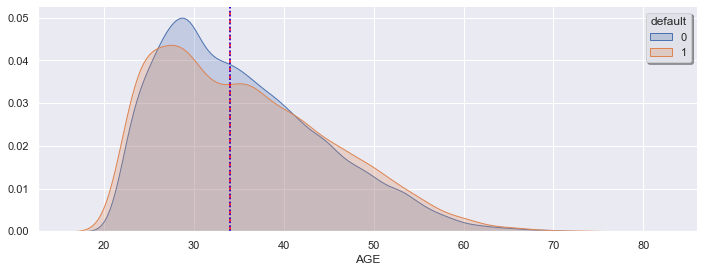

In [192]:
g = sns.FacetGrid(data=data[['AGE', 'default']], hue='default', 
                 height=4, aspect=2.5, legend_out=False)
g.map(sns.kdeplot, 'AGE', fill=True)
g.add_legend(shadow=True, framealpha=0.9)
g.ax.axvline(data_def.AGE.median(), ls='dashed', color='red')
g.ax.axvline(data_ret.AGE.median(), ls=':', color='blue')
plt.show()

На первый взгляд, распределения практически совпадают, а медианы совпадают, проверим так ли это, посчитав выборочные медианы и воспользовавшись критерием Манна-Уитни:

In [193]:
print(f'default=0: \n median = {data_ret.AGE.median()}')
print(f'default=1: \n median = {data_def.AGE.median()}')

default=0: 
 median = 34.0
default=1: 
 median = 34.0


Выборочные медианы в точности совпадают, а значит мы не можем ни при каких условиях отвергнуть нулевую гипотезу о равенстве медиан возврастов вернувших и не вернувших кредит.

In [32]:
sts.mannwhitneyu(data_ret.AGE, data_def.AGE, alternative = 'two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

#### Критерий Манна-Уитни дает достигаемый уровень значимости 0.37, значит нельзя отвергнуть нулевую гипотезу о совпадении распределений возраста заемщиков, вернувших и не вернувших кредит. Таким образом, возраст заемщика не влияет на вероятность возврата им кредита.